# Unzip GTZAN playlist

In [ ]:
import zipfile
import os

# Define the path to the zip file and the destination directory
zip_file_path = '../cache/gtzan/archive.zip'
unpack_dir = '../cache/gtzan/'

# Create the destination directory if it doesn't exist
os.makedirs(unpack_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unpack_dir)

print(f"Contents unpacked to {unpack_dir}")

Contents unpacked to ../cache/gtzan/


# Calculate Features

In [1]:
# Import necessary libraries
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm


In [ ]:
/home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio/tensor_168.wav

In [24]:
import librosa
import soundfile as sf
from pydub import AudioSegment
from pydub.playback import play
import pyloudnorm as pyln

input_path = "/home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio/tensor_168.wav"
output_path = input_path.replace(".wav", "_normalized.wav")

audio, sr = librosa.load(input_path, sr=44100)

def normalize_lufs(y, target_lufs=-20):
    # Loudness normalization to -14 LUFS
    meter = pyln.Meter(sr)  # Create a meter
    loudness = meter.integrated_loudness(y)  # Measure current loudness
    y_normalized = pyln.normalize.loudness(y, loudness, target_loudness=target_lufs)  # Normalize

    return y_normalized

sf.write(output_path, normalize_lufs(audio), sr)
print(f"Normalized and saved: {output_path}")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio/tensor_168_normalized.wav


In [50]:
import os
import librosa
import soundfile as sf
import pyloudnorm as pyln

# Define the path to the input audio directory
input_path = "/home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio"

# Define the path to the output directory for normalized audio
output_path = os.path.join(os.path.dirname(input_path), "audio_normalized")
os.makedirs(output_path, exist_ok=True)  # Create the directory if it doesn't exist

# Loop through the files in the input directory
for f in os.listdir(input_path):
    if f.endswith(('.wav', '.mp3')):  # Ensure it's an audio file
        file_path = os.path.join(input_path, f)
        
        # Load the audio
        y, sr = librosa.load(file_path, sr=16000)
        
        # Loudness normalization to -14 LUFS
        meter = pyln.Meter(sr)  # Create a meter
        loudness = meter.integrated_loudness(y)  # Measure current loudness
        y_normalized = pyln.normalize.loudness(y, loudness, target_loudness=-14.0)  # Normalize
        
        # Save the normalized audio to the output directory
        output_file_path = os.path.join(output_path, f)
        sf.write(output_file_path, y_normalized, sr)
        print(f"Normalized and saved: {output_file_path}")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_575.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_907.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_114.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_662.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_797.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_509.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_168.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_741.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_858.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_900.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_572.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_113.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_617.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_276.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_1023.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_733.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvga

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_880.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_384.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_851.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_423.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_244.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_991.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_37.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_1011.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_243.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_1016.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_30.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_185.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_706.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_598.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_128.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_549.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_369.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_708.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_231.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_596.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_591.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_236.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_45.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_657.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_464.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_312.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_773.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_39.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_54.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_8.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_227.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_580.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_53.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_587.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_220.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_641.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_252.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_987.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_633.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_194.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_400.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_699.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_229.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_6.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_s

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_284.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_26.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_1000.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_980.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_395.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_725.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_891.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_344.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_392.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_847.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_435.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_722.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_750.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_496.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_331.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_674.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_61.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_212.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_916.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_564.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_336.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_491.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_419.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_44.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_95.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_817.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_465.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_313.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_948.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_368.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_709.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_43.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_410.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_862.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_366.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_707.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_239.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_658.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_689.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_819.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_533.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_941.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_294.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_735.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_798.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_506.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_974.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_167.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_1022.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_277.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_732.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_353.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvga

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_321.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_457.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_825.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_791.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_664.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_76.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_205.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_574.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_481.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_822.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_450.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_796.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_104.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_519.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_178.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_441.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_834.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_446.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_780.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_751.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_103.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_848.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_899.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_607.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_69.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_846.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_434.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_393.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_841.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_724.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_345.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_890.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_758.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_339.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_698.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_228.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_285.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_950.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_522.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_254.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_588.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_377.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_716.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_873.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_801.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_473.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_691.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_136.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_718.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_131.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_696.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_84.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_408.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_29.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_302.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_763.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_494.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_752.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_64.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_217.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_671.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_107.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_566.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_914.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_442.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_493.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_334.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_755.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_893.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_727.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_11.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_262.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_172.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_961.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_513.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_839.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_985.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_250.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_769.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_308.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_4.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_58.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_712.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_373.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_191.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_1002.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_24.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_257.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_56.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_582.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_225.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_879.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_528.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_149.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_198.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_767.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_135.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_643.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_51.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_222.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_652.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_594.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_233.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_40.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_593.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_47.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_96.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_930.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_s

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_629.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_248.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_299.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_414.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_627.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_993.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_246.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_1013.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvga

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_704.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_365.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_939.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_828.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_885.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_731.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_381.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_854.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_853.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_386.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_118.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_579.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_388.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_116.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_905.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_577.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_453.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_821.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_979.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_485.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_570.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_902.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_206.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_75.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_803.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_81.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_927.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_555.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_552.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_920.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_694.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_133.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_761.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_300.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_804.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_476.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_713.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_372.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_876.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_404.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_256.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_1003.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_25.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_478.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_984.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_22.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_1004.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_768.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_17.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_605.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_173.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_960.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_895.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_721.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_108.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_569.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_10.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_602.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_174.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_515.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_782.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_444.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_836.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_495.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_438.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_323.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_484.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_742.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_207.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_666.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_358.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_739.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_324.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_745.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_794.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_452.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_119.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_578.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_165.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_976.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_1020.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_275.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_614.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_884.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvga

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_318.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_186.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_621.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_33.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_860.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_412.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_705.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_364.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_469.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_626.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_181.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_1012.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvga

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home

Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_770.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_311.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_628.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio_normalized/tensor_249.wav
Normalized and saved: /home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


In [3]:
# Initialize a list to store the feature data
data = []

ssd_cap = 200
ssd_looper = 0
gtzan_cap = 100
gtzan_looper = 0

In [104]:
import pyloudnorm as pyln

# Function to extract features from a given .wav file
def extract_features(file_path, label, normalize_level=None):
    try:
        y, sr = librosa.load(file_path, sr=44100)
        
        if normalize_level:
            meter = pyln.Meter(sr)  # Create a meter
            loudness = meter.integrated_loudness(y)  # Measure current loudness
            y = pyln.normalize.loudness(y, loudness, target_loudness=normalize_level)

        # Extract features
        length = librosa.get_duration(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
        harmony = librosa.effects.harmonic(y)
        perceptr = librosa.effects.percussive(y)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)

        # Calculate ASR (Articulation Feature)
        rms_energy = rms[0]
        asr = np.sum(rms_energy < np.mean(rms_energy)) / len(rms_energy)

        # Calculate Onset Envelope Features
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        oenv_mean = np.mean(onset_env)
        oenv_var = np.var(onset_env)
        oenv_std = np.std(onset_env)

        # Calculate Spectral Flatness Features
        flatness = librosa.feature.spectral_flatness(y=y)
        flatness_mean = np.mean(flatness)
        flatness_var = np.var(flatness)
        flatness_std = np.std(flatness)

        # Aggregate features
        features = [
            os.path.basename(file_path),
            length,
            np.mean(chroma_stft), np.var(chroma_stft),
            np.mean(rms), np.var(rms), np.std(rms),
            np.mean(spectral_centroid), np.var(spectral_centroid),
            np.mean(spectral_bandwidth), np.var(spectral_bandwidth),
            np.mean(rolloff), np.var(rolloff), np.std(rolloff),
            np.mean(zero_crossing_rate), np.var(zero_crossing_rate),
            np.mean(harmony), np.var(harmony),
            np.mean(perceptr), np.var(perceptr),
            tempo[0],
            asr,
            oenv_mean, oenv_var, oenv_std,
            flatness_mean, flatness_var, flatness_std
        ]

        # Add MFCC features (only means as per the paper)
        for i in range(20):
            features.append(np.mean(mfcc[i]))

        # Append the label
        features.append(label)

        return features
    
    except Exception as e:
        # If an error occurs, print the error and skip this file
        print(f"Error processing {file_path}: {e}")
        return None
 
def loop_over_dir(dir_name):
    def get_label(dir_name):
        if 'sleep' in dir_name: 
            return 'Spotify Sleep Dataset'
        elif 'bigvgan' in dir_name: 
            if '2048' in dir_name: return 'bigvgan 2048 128'
            else: return 'bigvgan 512 128'
        elif 'ssd_512_256' in dir_name: 
            return 'Generated 512,256 Spotify Sleep Dataset'
        elif 'ssd_2048_128' in dir_name: 
            return 'Generated 2048,128 Spotify Sleep Dataset'
        elif 'fma_pop' in dir_name: 
            return 'FMA POP'
        elif 'musiccaps' in dir_name: 
            return 'MusicCaps' 
        elif 'drum' in dir_name: 
            return 'Drum Samples'
        else: 
            return 'Unknown Dataset'

    if 'gtzan' in dir_name:
        for genre in os.listdir(dir_name):
            genre_dir = os.path.join(dir_name, genre)
            if os.path.isdir(genre_dir):
                gtzan_looper = 0
                for filename in tqdm(os.listdir(genre_dir), desc=f'Processing GTZAN dataset genre: {genre}'):
                    if gtzan_looper < gtzan_cap:
                        if filename.endswith(('.wav', '.mp3')):
                            file_path = os.path.join(genre_dir, filename)
                            features = extract_features(file_path, label=genre)
                            if features is not None:  # Skip files that failed to process
                                data.append(features)
                                gtzan_looper += 1
    else:
        ssd_looper = 0
        for filename in tqdm(os.listdir(dir_name), desc=f'Processing {dir_name} dataset'):
            if ssd_looper < ssd_cap:
                if filename.endswith(('.wav', '.mp3')):
                    file_path = os.path.join(dir_name, filename)
                    label = get_label(dir_name)
                    features = extract_features(file_path, label=label)
                    if features is not None:  # Skip files that failed to process
                        data.append(features)
                        ssd_looper += 1


In [105]:
# Directory paths
spotify_directory = '../cache/spotify_sleep_dataset/waveform'
gtzan_directory = '../cache/gtzan/Data/genres_original'
fma_pop_directory = '../cache/fma_pop/waveform/'
musiccaps_directory = '../cache/musiccaps/waveform'
drum_samples_directory = '../cache/drum_samples/waveform'
ssd_sleep_only = '../cache/spotify_sleep_dataset/waveform_sleep_only'

generated_sleep_samples_512_256 = '../models/ra_ssd_512_256/model_step_50000/samples/audio/sch_ddpm_nisteps_1000'
generated_sleep_samples_2048_128 = '/home/th716/audio-diffusion/models/ra_ssd_2048_128/model_step_90000/samples/audio/sch_ddpm_nisteps_1000'
generated_ssd_sleep_only_2048_128 = '/home/th716/audio-diffusion/models/ra_ssd_sleep_only_2048_128/model_step_90000/samples/audio/sch_ddpm_nisteps_1000'
generated_bigvgan_512_128_dir = "/home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_512_128_so_bigvgan/model_step_195000/samples/bigvgan/audio"
generated_bigvgan_2048_128_dir = "/home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio"

# Define column names
columns = [
    'filename', 'length', 'chroma_stft_mean', 'chroma_stft_var',
    'rms_mean', 'rms_var', 'rms_std', 'spectral_centroid_mean', 'spectral_centroid_var',
    'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'rolloff_std',
    'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var',
    'perceptr_mean', 'perceptr_var', 'tempo', 'asr',
    'oenv_mean', 'oenv_var', 'oenv_std',
    'flatness_mean', 'flatness_var', 'flatness_std'
]

# Add MFCC columns
for i in range(1, 21):
    columns.append(f'mfcc{i}_mean')

# Add label column
columns.append('label')

for dir_name in [ssd_sleep_only]:
    loop_over_dir(dir_name)


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   0%|          | 2/19009 [00:13<35:49:18,  6.78s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/2LWiQdlMF9mMzvunrVn76m.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   0%|          | 7/19009 [00:45<33:08:38,  6.28s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/1bEWJwe5LcPgBkrCHkBZuU.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   0%|          | 37/19009 [03:58<33:10:37,  6.30s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/2v1hMFRLSYmkBEJuNXwRI1.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   0%|          | 39/19009 [04:10<32:34:17,  6.18s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/1t2GA3Kl5axE5JzRGWQF7k.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   0%|          | 45/19009 [04:48<32:25:02,  6.15s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/2ofBNSAGaqEzL7bPXfiMq8.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   0%|          | 47/19009 [05:00<32:34:48,  6.19s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/7xz39PtQmkMr4uax9lNI8U.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   0%|          | 55/19009 [05:51<33:30:31,  6.36s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/7qs4XlOcmJKWbmIfHV77rP.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   0%|          | 56/19009 [05:57<32:53:27,  6.25s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/6EFnrGXVoAGDwWIkbLRyjV.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   0%|          | 84/19009 [08:57<33:33:05,  6.38s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/7EXjGid9A0PK7TGHv71cAC.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   0%|          | 89/19009 [09:30<33:57:04,  6.46s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/2lvQ284NOTsyUabjzKfYJW.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   0%|          | 93/19009 [09:55<33:08:10,  6.31s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/7bjxBwnzjiPoUXWMzOa20t.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   1%|          | 97/19009 [10:20<32:53:49,  6.26s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/4h0Z2nEc405jk1n10pPIjg.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   1%|          | 108/19009 [11:31<33:44:04,  6.43s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/2SVRIRpifCb6oWCg4ffKhl.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   1%|          | 124/19009 [13:12<32:58:06,  6.28s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/7gZC0SYPFTYw4oG5w6X9E3.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   1%|          | 127/19009 [13:31<32:51:13,  6.26s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/0jfHHmeb9XwJAfoQeR15cQ.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   1%|          | 134/19009 [14:15<32:18:02,  6.16s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/4UbjKlu2nv3cn41WwRevhR.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   1%|          | 143/19009 [15:10<32:08:58,  6.13s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/04WcJbOTNx94r1Dsuq1TA8.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   1%|          | 152/19009 [16:07<33:04:43,  6.32s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/70QdftwFU1m9evUD3kACqP.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   1%|          | 161/19009 [17:04<32:53:41,  6.28s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/1iFSyZXnosG4M0JtgHZrGu.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   1%|          | 179/19009 [18:55<31:29:40,  6.02s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/0AwUOUfNuPq7Kfo8t2MN0g.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   1%|          | 187/19009 [19:44<31:35:39,  6.04s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/4Kcp1c8L2Z6GCwHPnoTKft.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   1%|          | 194/19009 [20:28<32:16:23,  6.18s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/1ysmJwjwI0KXe1rjKlKeHv.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   1%|          | 209/19009 [22:01<31:28:05,  6.03s/it]

Error processing ../cache/spotify_sleep_dataset/waveform_sleep_only/3XtevPnGjkBQyEibq768k2.wav: 'float' object is not subscriptable


Processing ../cache/spotify_sleep_dataset/waveform_sleep_only dataset:   1%|          | 212/19009 [22:24<33:06:46,  6.34s/it]


KeyboardInterrupt: 

In [112]:
df = pd.DataFrame(data, columns=columns)
ssd_df = df[df['label'] == 'Spotify Sleep Dataset']

ssd_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,rms_std,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,label
400,0fSTIQOL1S5WSjHhoaX9ll.wav,30.000023,0.386485,0.094285,0.027598,0.000092,0.009608,1320.410119,75066.781562,2123.505816,...,-1.525729,1.473912,0.989195,3.803362,-3.793706,-1.686580,-2.655390,-2.846109,-0.355289,Spotify Sleep Dataset
401,0TyDXrWpsw0RGg59tAD39K.wav,30.000000,0.379938,0.079447,0.039208,0.000036,0.006023,565.449702,3369.626231,809.033279,...,-1.593872,-1.655277,1.368370,0.259264,-1.113249,-0.233507,-2.845327,-0.556130,-4.486314,Spotify Sleep Dataset
402,1HOGlVABDU7dNpMKPHFi3T.wav,30.000000,0.467161,0.078237,0.098104,0.000839,0.028964,437.052728,3683.661455,673.289381,...,-0.866498,-2.737180,-3.694530,0.789713,3.937910,2.434504,2.155013,0.801028,-1.734963,Spotify Sleep Dataset
403,6blvCvQJpNgjCVBRLSAICe.wav,30.000000,0.307533,0.100981,0.061778,0.000391,0.019765,868.475429,22028.948123,1281.008162,...,-10.586224,-16.474657,-11.727461,-9.907145,-12.935767,-19.930208,-23.144779,-9.547909,3.863847,Spotify Sleep Dataset
404,5rxFfpGUKdpsbhLBE51F1b.wav,30.000000,0.343832,0.084332,0.047435,0.000181,0.013464,447.795019,2233.254715,578.740882,...,-9.440598,-15.969947,-15.996943,-6.597629,-6.065294,-8.221721,-8.259226,-9.865305,-10.671079,Spotify Sleep Dataset
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,671wRPUA6GLz2P0cEhqiZP.wav,30.000023,0.435572,0.089463,0.028587,0.000122,0.011031,504.801984,3471.323564,1042.952486,...,4.872013,9.173562,5.343203,-1.277744,-5.426960,-2.513056,4.012323,9.186588,8.047850,Spotify Sleep Dataset
585,30G2HJmNVxT8eLftBb61PZ.wav,30.000023,0.304331,0.085622,0.067032,0.000500,0.022370,773.356557,14138.686357,1126.303092,...,-4.925985,-4.816080,-4.914388,-3.291243,-7.216328,-5.844047,-2.712119,-2.576171,-0.328334,Spotify Sleep Dataset
586,7DuBIsqpV0ZEJHcvjB8M5p.wav,30.000023,0.509639,0.097907,0.033742,0.000136,0.011683,1058.015679,93566.574004,2147.190464,...,1.282429,2.726641,-2.342818,1.844668,-4.591820,2.273798,-0.980452,2.262503,0.343341,Spotify Sleep Dataset
587,4alPEOoaf7AdXiJc1tIQw9.wav,30.000023,0.354986,0.094296,0.026437,0.000552,0.023487,449.983321,6226.404576,551.598964,...,7.359290,12.419612,6.460207,-1.107716,-4.340297,-5.966620,-7.103081,-5.716680,-3.490016,Spotify Sleep Dataset


In [113]:
ssd_df.to_csv('../results/ssd_features.csv')

In [114]:
df = pd.read_csv('../results/feature_checking.csv')

In [68]:
df.to_csv('../results/feature_checking.csv')

In [71]:
good_df = df[df['index'].isin(good_inds)]
good_df['label'] = 1
bad_df = df[df['index'].isin(bad_inds)]
bad_df['label'] = 0

/tmp/ipykernel_1233235/1882659076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_df['label'] = 1
/tmp/ipykernel_1233235/1882659076.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_df['label'] = 0


### Statistical Analysis

In [86]:
indexes = [(name.split("_")[1].split('.')[0], lbl) for name, lbl in zip(df['filename'], df['label'])]
indexes

[('575', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('907', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('114', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('662', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('203', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('70', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('746', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('480', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('327', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('823', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('451', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('797', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('509', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('168', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('741', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('320', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('487', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('456', 'Generated 2048,128 Spotify Sleep Dataset'),
 ('824', 'Generated 2048,128 

In [88]:
good_inds = [575, 907, 114, 662, 746, 327, 797, 168, 456, 790, 889, 900, 113, 665, 204, 77, 489, 458, 972, 161, 276, 352, 424, 856, 79, 734, 851, 423, 909, 748, 329, 799, 1024, 864]
bad_inds = [203, 70, 480, 823, 451, 509, 741, 320, 487, 824, 278, 619, 858, 572, 500, 617, 1023, 733, 887, 383, 355, 880, 384, 507, 975, 166, 610, 271]

good_df = df[df['index'].isin(good_inds)]
good_df['label'] = 1
good_df.to_csv('../results/good_audio_df.csv')
bad_df = df[df['index'].isin(bad_inds)]
bad_df['label'] = 0
bad_df.to_csv('../results/bad_audio_df.csv')

/tmp/ipykernel_1233235/2507592296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_df['label'] = 1
/tmp/ipykernel_1233235/2507592296.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_df['label'] = 0


In [89]:
good_df[['index', 'rms_mean', 'harmony_var', 'mfcc1_mean', 'label']]

,index,rms_mean,harmony_var,mfcc1_mean,label
0,575,0.268086,0.060253,-63.332829,1
1,907,0.675098,0.263127,88.861473,1
2,114,0.546025,0.112070,41.531433,1
3,662,0.513263,0.237801,-49.821552,1
6,746,0.572608,0.243732,-21.970022,1
8,327,0.583920,0.131524,65.125786,1
11,797,0.631111,0.297407,63.473328,1
13,168,0.641319,0.298744,64.371483,1
17,456,0.512677,0.080555,18.166115,1
19,790,0.581858,0.105760,43.958263,1


In [90]:
bad_df[['index', 'rms_mean', 'harmony_var', 'mfcc1_mean']]

,index,rms_mean,harmony_var,mfcc1_mean
4,203,0.492795,0.176129,-99.280441
5,70,0.075056,0.003875,-209.505707
7,480,0.103277,0.010911,-280.703094
9,823,0.140321,0.016954,-146.334915
10,451,0.031329,0.000928,-373.024017
12,509,0.005078,0.000030,-436.328796
14,741,0.117737,0.011572,-305.017548
15,320,0.185205,0.030140,-186.528915
16,487,0.099311,0.009247,-208.893402
18,824,0.004868,0.000025,-702.946594


In [91]:
Feature chroma_stft_var is significantly different (p = 1.086e-02)
Feature rms_mean is significantly different (p = 2.592e-05)
Feature rms_std is significantly different (p = 2.140e-02)
Feature spectral_bandwidth_var is significantly different (p = 3.603e-02)
Feature harmony_var is significantly different (p = 2.166e-03)
Feature perceptr_var is significantly different (p = 1.850e-03)
Feature asr is significantly different (p = 9.341e-04)
Feature mfcc1_mean is significantly different (p = 2.723e-04)
Feature mfcc4_mean is significantly different (p = 4.247e-02)

SyntaxError: invalid syntax (2873873496.py, line 1)

Feature harmony_mean is significantly different (p = 3.274e-02)
Feature perceptr_mean is significantly different (p = 2.287e-02)
Feature perceptr_var is significantly different (p = 2.776e-02)
Feature mfcc9_mean is significantly different (p = 4.470e-02)


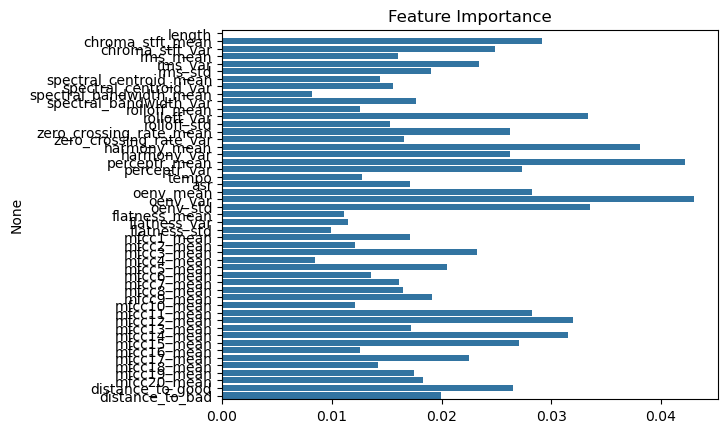

Optimal threshold for harmony_mean: -0.0013124302495270967
Optimal threshold for perceptr_mean: -0.003825151128694415
Optimal threshold for perceptr_var: 2.320651947229635e-05
Optimal threshold for mfcc9_mean: -0.9061083197593689


In [93]:
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Statistical Tests
significant_features = []
for feature in bad_df.columns[1:-1]:  # Exclude filename and label columns
    if not feature in ['label', 'index', 'filename', 'length']:
        stat, p = ttest_ind(good_df[feature], bad_df[feature], equal_var=False)
        if p < 0.05:
            significant_features.append(feature)
            print(f"Feature {feature} is significantly different (p = {p:.3e})")

# 2. Feature Importance via Random Forest
X = pd.concat([good_df, bad_df]).drop(['filename', 'label', 'index'], axis=1)
y = pd.concat([good_df['label'], bad_df['label']])
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importance = rf.feature_importances_

# Plot feature importance
sns.barplot(x=importance, y=X.columns)
plt.title("Feature Importance")
plt.show()

# 3. Threshold Analysis
for feature in significant_features:  # From statistical tests or RF ranking
    fpr, tpr, thresholds = roc_curve(y, X[feature])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold for {feature}: {optimal_threshold}")


### calculate distances to good and bad samples, using significant features selection

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# Significant features
significant_features = [
    'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'rms_std',
    'spectral_bandwidth_var', 'harmony_var', 'perceptr_var', 'asr', 'mfcc1_mean'
]

# 1. Compute means of significant features
good_means = good_df[significant_features].mean()
bad_means = bad_df[significant_features].mean()

# 2. Normalize the data (optional)
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df[significant_features])
good_means_normalized = scaler.transform([good_means])
bad_means_normalized = scaler.transform([bad_means])

# 3. Compute distances
distances_to_good = cdist(df_normalized, good_means_normalized, metric='euclidean').flatten()
distances_to_bad = cdist(df_normalized, bad_means_normalized, metric='euclidean').flatten()

# 4. Select top 20 closest audios
df['distance_to_good'] = distances_to_good
df['distance_to_bad'] = distances_to_bad

top_good = df.nsmallest(50, 'distance_to_good')
top_bad = df.nsmallest(50, 'distance_to_bad')

# Display selected audios
print("Top 20 closest audios to good:")
print(top_good[['filename', 'distance_to_good']])
top_good_files = [name for name in top_good['filename']]

print("\nTop 20 closest audios to bad:")
print(top_bad[['filename', 'distance_to_bad']])
top_bad_files = [name for name in top_bad['filename']]

Top 20 closest audios to good:
            filename  distance_to_good
49    tensor_851.wav          1.030535
153   tensor_556.wav          1.067798
60   tensor_1024.wav          1.079465
247   tensor_502.wav          1.120096
107   tensor_650.wav          1.156059
80    tensor_243.wav          1.180206
15    tensor_320.wav          1.192317
191    tensor_26.wav          1.247764
31    tensor_458.wav          1.249539
52    tensor_748.wav          1.257127
113   tensor_418.wav          1.289296
87    tensor_535.wav          1.303657
272   tensor_939.wav          1.325185
393   tensor_109.wav          1.364743
319    tensor_19.wav          1.386163
85    tensor_154.wav          1.394102
378   tensor_265.wav          1.397967
330   tensor_132.wav          1.422988
189   tensor_523.wav          1.434819
72   tensor_1011.wav          1.446597
99   tensor_1018.wav          1.458623
267   tensor_537.wav          1.482230
61    tensor_864.wav          1.486525
246   tensor_970.wav          1.4

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### calculate distances from ground truth means

In [119]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# Define significant features, excluding non-numerical or unrelated columns
significant_features = df.columns.drop(['label', 'index', 'filename', 'length', 'Unnamed: 0'])

# 1. Compute the mean of significant features from ssd_df (good samples)
good_means = ssd_df[significant_features].mean()

# 2. Normalize the data (optional but recommended for consistency)
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df[significant_features])  # Normalize df
good_means_normalized = scaler.transform([good_means])          # Normalize the mean vector

# 3. Compute distances between each row in df and the good sample mean
distances_to_good = cdist(df_normalized, good_means_normalized, metric='euclidean').flatten()

# 4. Add the distances to the original df for reference
df['distances_to_good'] = distances_to_good

# 5. Select the top 50 closest rows (smallest distances)
top_good_matches = df.nsmallest(50, 'distances_to_good')

# Display the results
print("Top 50 closest rows to the good samples' mean:")
print(top_good_matches[['filename', 'distances_to_good']])

# Save the filenames of the closest matches
top_good_files = top_good_matches['filename'].tolist()


Top 50 closest rows to the good samples' mean:
            filename  distances_to_good
175   tensor_376.wav           4.525428
34    tensor_161.wav           4.640004
101   tensor_949.wav           4.698710
45    tensor_734.wav           5.029342
200   tensor_743.wav           5.063456
124   tensor_464.wav           5.146479
74    tensor_182.wav           5.148586
119   tensor_686.wav           5.175158
180   tensor_229.wav           5.198782
88    tensor_292.wav           5.223322
5      tensor_70.wav           5.229265
16    tensor_487.wav           5.287343
133    tensor_54.wav           5.345712
149   tensor_800.wav           5.360706
129   tensor_130.wav           5.362091
71     tensor_37.wav           5.369510
324   tensor_554.wav           5.374306
398   tensor_346.wav           5.500484
165   tensor_956.wav           5.541214
75    tensor_153.wav           5.542073
80    tensor_243.wav           5.565904
103   tensor_708.wav           5.612009
338    tensor_62.wav           5.

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [101]:
top_good_files

['tensor_851.wav',
 'tensor_556.wav',
 'tensor_1024.wav',
 'tensor_502.wav',
 'tensor_650.wav',
 'tensor_243.wav',
 'tensor_320.wav',
 'tensor_26.wav',
 'tensor_458.wav',
 'tensor_748.wav',
 'tensor_418.wav',
 'tensor_535.wav',
 'tensor_939.wav',
 'tensor_109.wav',
 'tensor_19.wav',
 'tensor_154.wav',
 'tensor_265.wav',
 'tensor_132.wav',
 'tensor_523.wav',
 'tensor_1011.wav',
 'tensor_1018.wav',
 'tensor_537.wav',
 'tensor_864.wav',
 'tensor_970.wav',
 'tensor_423.wav',
 'tensor_10.wav',
 'tensor_545.wav',
 'tensor_17.wav',
 'tensor_325.wav',
 'tensor_875.wav',
 'tensor_619.wav',
 'tensor_935.wav',
 'tensor_390.wav',
 'tensor_528.wav',
 'tensor_572.wav',
 'tensor_690.wav',
 'tensor_816.wav',
 'tensor_646.wav',
 'tensor_182.wav',
 'tensor_845.wav',
 'tensor_37.wav',
 'tensor_643.wav',
 'tensor_374.wav',
 'tensor_839.wav',
 'tensor_524.wav',
 'tensor_909.wav',
 'tensor_453.wav',
 'tensor_980.wav',
 'tensor_575.wav',
 'tensor_710.wav']

In [103]:
import os
import shutil

path = "/home/th716/BigVGAN/hpc_directories/home/th716/rds/hpc-work/audio-diffusion/models/final_models/final_ssd_2048_128_bigvgan_so/model_step_130000/samples/bigvgan/audio"

top_good_path = path.replace('bigvgan/audio', 'bigvgan/top_good')
top_bad_path = path.replace('bigvgan/audio', 'bigvgan/top_bad')

os.makedirs(top_good_path, exist_ok=True)
os.makedirs(top_bad_path, exist_ok=True)

for f in os.listdir(path):
    full_file_path = os.path.join(path, f) 
    
    if f in top_good_files:
        shutil.copy(full_file_path, top_good_path)
    elif f in top_bad_files:
        shutil.copy(full_file_path, top_bad_path) 


In [5]:
df = pd.DataFrame(data, columns=columns)
df.to_csv('csv/musical_features_sleep_only.csv', index=False)

print('Feature extraction complete. Saved to musical_features.csv')

Feature extraction complete. Saved to musical_features.csv


In [6]:
df = pd.read_csv('csv/musical_features_sleep_only.csv')

In [9]:
df.loc[:199, 'label'] = 'Spotify Sleep Dataset Sleep Only'
df.loc[200:399, 'label'] = 'SSD Sleep Only 2048,128'

In [114]:
def clean_up_label(txt):
    if txt in ['disco', 'rock', 'blues', 'country', 'pop', 'classical', 'hiphop', 'jazz', 'reggae', 'metal']:
        return f'gtzan: {txt}'
    elif txt == 'sleep':
        return 'Spotify Sleep Dataset'
    else: 
        return txt
    
df['label'] = df['label'].apply(lambda x: clean_up_label(x))

In [ ]:
df_mf = pd.read_csv('csv/musical_features.csv')
df_mf_so = pd.read_csv('csv/musical_features_sleep_only.csv')

In [23]:
df = pd.concat([df_mf, df_mf_so])

In [24]:
from sklearn.preprocessing import MinMaxScaler

exclude_columns = ['filename', 'length', 'label']

df_n = df.copy()

scaler = MinMaxScaler()

df_n.loc[:, ~df_n.columns.isin(exclude_columns)] = scaler.fit_transform(
    df_n.loc[:, ~df_n.columns.isin(exclude_columns)]
)

df_n.to_csv('csv/musical_features_all_normalized.csv', index=False)

### Plot Analysis Results

In [13]:
df_n = pd.read_csv('csv/musical_features_sleep_only_all_normalized.csv')

In [14]:
tmp = pd.read_csv('csv/musical_features_all_normalized.csv')

In [18]:
df = pd.concat([df_n, tmp])

In [21]:
df_n.to_csv('csv/musical_features_all_normalized.csv', index=False)

In [ ]:
df_n['label'].unique()

array(['Generated 512,256 Spotify Sleep Dataset',
       'Generated 2048,128 Spotify Sleep Dataset',
       'Spotify Sleep Dataset', 'gtzan: disco', 'gtzan: rock',
       'gtzan: blues', 'gtzan: country', 'gtzan: pop', 'gtzan: classical',
       'gtzan: hiphop', 'gtzan: jazz', 'gtzan: reggae', 'gtzan: metal',
       'FMA POP', 'MusicCaps', 'Drum Samples'], dtype=object)

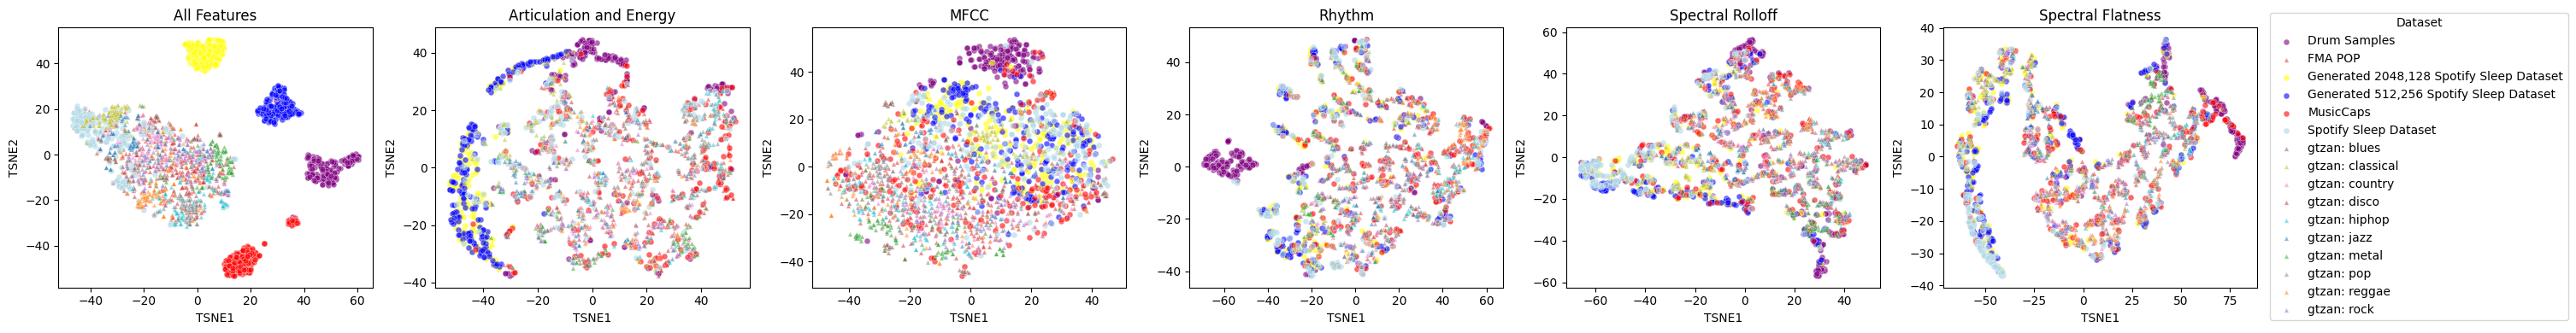

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Define feature groups according to the paper
articulation_energy_features = ['asr', 'rms_mean', 'rms_var', 'rms_std']
mfcc_features = [f'mfcc{i}_mean' for i in range(1, 21)]
rhythm_features = ['oenv_mean', 'oenv_var', 'oenv_std', 'tempo']
spectral_rolloff_features = ['rolloff_mean', 'rolloff_var', 'rolloff_std']
spectral_flatness_features = ['flatness_mean', 'flatness_var', 'flatness_std']

# Grouping for visualization
feature_groups = {
    'All Features': df_n.columns[1:-1].tolist(),
    'Articulation and Energy': articulation_energy_features,
    'MFCC': mfcc_features,
    'Rhythm': rhythm_features,
    'Spectral Rolloff': spectral_rolloff_features,
    'Spectral Flatness': spectral_flatness_features
}

# Manually specify a color palette for the highlighted labels
highlight_labels = {
    'Spotify Sleep Dataset': 'lightblue',
    'Generated 512,256 Spotify Sleep Dataset': 'blue',
    'Generated 2048,128 Spotify Sleep Dataset': 'yellow',
    'FMA Pop': 'orange',
    'MusicCaps': 'red',
    'Drum Samples': 'purple'
}

# Generate a palette for the remaining labels
unique_labels = df_n['label'].unique()
palette = sns.color_palette("tab10", len(unique_labels))
palette_dict = {label: palette[i] for i, label in enumerate(unique_labels)}

# Function to plot t-SNE on a given axis
def plot_tsne(ax, features, title):
    X = df_n[features].values
    y = df_n['label'].values
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    
    tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    tsne_df['label'] = y
    
    # Plot the labels
    for label in np.unique(y):
        if label in highlight_labels:
            color = highlight_labels[label]
            size = 25  # Larger points for highlighted labels
            alpha = 0.6  # Bold colors
            marker = 'o'
        else:
            color = palette_dict[label]
            size = 15  # Smaller points for other labels
            alpha = 0.5  # Washed out color
            marker = '^'
        
        sns.scatterplot(
            x='TSNE1', y='TSNE2',
            data=tsne_df[tsne_df['label'] == label],
            color=color,
            s=size,
            alpha=alpha,
            marker=marker,
            ax=ax,
            label=label
        )
    
    ax.set_title(title)
    ax.legend_.remove()  # Remove individual legends

# Create subplots
fig, axs = plt.subplots(1, len(feature_groups), figsize=(28, 4), sharex=False, sharey=False)

# Plot each t-SNE
for ax, (name, features) in zip(axs, feature_groups.items()):
    plot_tsne(ax, features, f'{name}')

# Create a single legend directly to the right of the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', title='Dataset', bbox_to_anchor=(0.95, 0.5), borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the layout to make space for the legend
plt.savefig('images/musical_feature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
df_n['label'].unique()

array(['Generated 512,256 Spotify Sleep Dataset',
       'Generated 2048,128 Spotify Sleep Dataset',
       'Spotify Sleep Dataset', 'gtzan: disco', 'gtzan: rock',
       'gtzan: blues', 'gtzan: country', 'gtzan: pop', 'gtzan: classical',
       'gtzan: hiphop', 'gtzan: jazz', 'gtzan: reggae', 'gtzan: metal',
       'FMA POP', 'MusicCaps', 'Drum Samples'], dtype=object)

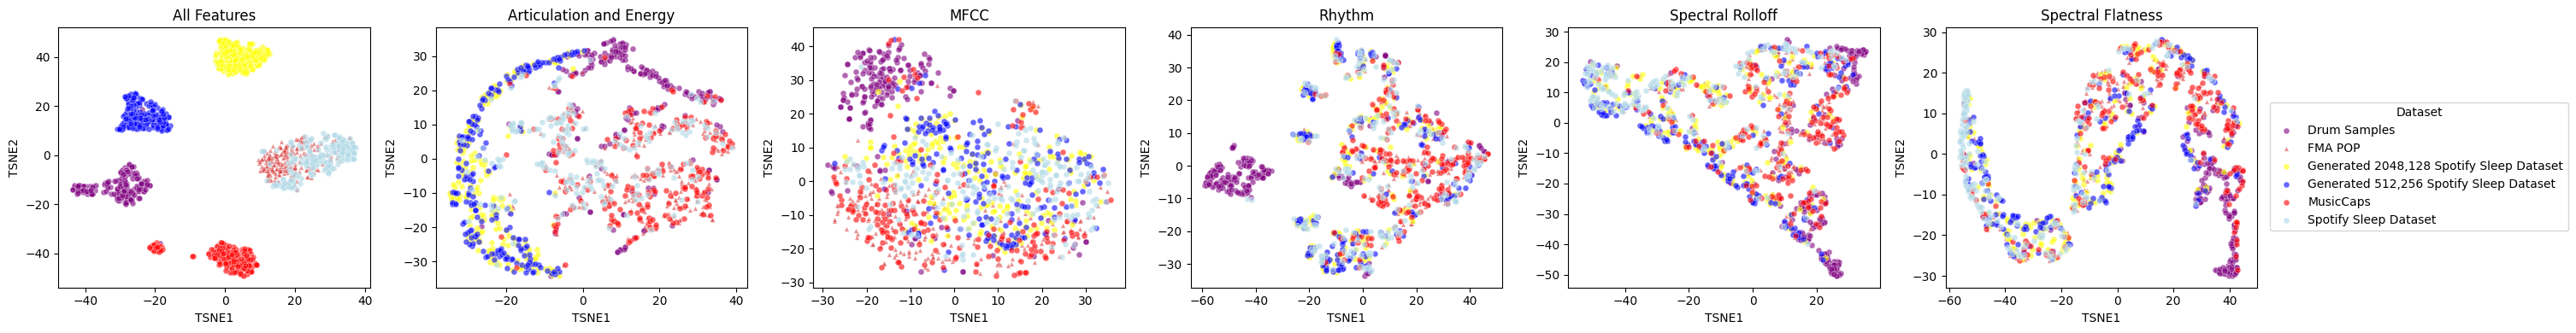

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

labels_to_keep = ['Spotify Sleep Dataset', 'Generated 512,256 Spotify Sleep Dataset', 'Generated 2048,128 Spotify Sleep Dataset', 'MusicCaps', 'Drum Samples', 'FMA POP']
filtered_df = df_n[df_n['label'].isin(labels_to_keep)]

# Define feature groups according to the paper
articulation_energy_features = ['asr', 'rms_mean', 'rms_var', 'rms_std']
mfcc_features = [f'mfcc{i}_mean' for i in range(1, 21)]
rhythm_features = ['oenv_mean', 'oenv_var', 'oenv_std', 'tempo']
spectral_rolloff_features = ['rolloff_mean', 'rolloff_var', 'rolloff_std']
spectral_flatness_features = ['flatness_mean', 'flatness_var', 'flatness_std']

# Grouping for visualization
feature_groups = {
    'All Features': filtered_df.columns[1:-1].tolist(),
    'Articulation and Energy': articulation_energy_features,
    'MFCC': mfcc_features,
    'Rhythm': rhythm_features,
    'Spectral Rolloff': spectral_rolloff_features,
    'Spectral Flatness': spectral_flatness_features
}

highlight_labels = {
    'Spotify Sleep Dataset': 'lightblue',
    'Generated 512,256 Spotify Sleep Dataset': 'blue',
    'Generated 2048,128 Spotify Sleep Dataset': 'yellow',
    'FMA Pop': 'orange',
    'MusicCaps': 'red',
    'Drum Samples': 'purple'
}


# Generate a palette for the remaining labels
unique_labels = filtered_df['label'].unique()
palette = sns.color_palette("tab10", len(unique_labels))
palette_dict = {label: palette[i] for i, label in enumerate(unique_labels)}

# Function to plot t-SNE on a given axis
def plot_tsne(ax, features, title):
    X = filtered_df[features].values
    y = filtered_df['label'].values
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    
    tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    tsne_df['label'] = y
    
    # Plot the labels
    for label in np.unique(y):
        if label in highlight_labels:
            color = highlight_labels[label]
            size = 25  # Larger points for highlighted labels
            alpha = 0.6  # Bold colors
            marker = 'o'
        else:
            color = palette_dict[label]
            size = 15  # Smaller points for other labels
            alpha = 0.5  # Washed out color
            marker = '^'
        
        sns.scatterplot(
            x='TSNE1', y='TSNE2',
            data=tsne_df[tsne_df['label'] == label],
            color=color,
            s=size,
            alpha=alpha,
            marker=marker,
            ax=ax,
            label=label
        )
    
    ax.set_title(title)
    ax.legend_.remove()  # Remove individual legends

# Create subplots
fig, axs = plt.subplots(1, len(feature_groups), figsize=(28, 4), sharex=False, sharey=False)

# Plot each t-SNE
for ax, (name, features) in zip(axs, feature_groups.items()):
    plot_tsne(ax, features, f'{name}')

# Create a single legend directly to the right of the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', title='Dataset', bbox_to_anchor=(0.95, 0.5), borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the layout to make space for the legend
plt.savefig('images/musical_feature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### TODO

- make plot with only spotify sleep dataset and generated dataset

### Musical Feature Analysis

In [40]:
articulation_energy_features = ['asr', 'rms_mean', 'rms_var', 'rms_std']
mfcc_features = [f'mfcc{i}_mean' for i in range(1, 21)]
rhythm_features = ['oenv_mean', 'oenv_var', 'oenv_std', 'tempo']
spectral_rolloff_features = ['rolloff_mean', 'rolloff_var', 'rolloff_std']
spectral_flatness_features = ['flatness_mean', 'flatness_var', 'flatness_std']


In [42]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame with all the features and 'label' column
df = pd.read_csv("musical_features_all.csv")  # Load your DataFrame

# Define the feature groups based on your clarification
articulation_energy_features = ['asr', 'rms_mean', 'rms_var', 'rms_std']
mfcc_features = [f'mfcc{i}_mean' for i in range(1, 21)]
rhythm_features = ['oenv_mean', 'oenv_var', 'oenv_std', 'tempo']
spectral_rolloff_features = ['rolloff_mean', 'rolloff_var', 'rolloff_std']
spectral_flatness_features = ['flatness_mean', 'flatness_var', 'flatness_std']

# Grouping features as described
feature_groups = {
    "All 34 musical features": df.drop(columns=['filename', 'label', 'length']),
    "Only articulation and energy features": df[articulation_energy_features],
    "Only MFCC features": df[mfcc_features],
    "Only rhythm features": df[rhythm_features],
    "Only spectral rolloff features": df[spectral_rolloff_features],
    "Only spectral flatness features": df[spectral_flatness_features]
}

# Labels to focus on
labels_of_interest = ['Drum Samples', 'FMA Pop', 'MusicCaps', 'Spotify Sleep Dataset', 'Spotify Sleep Dataset Generated']

# Initialize results DataFrame
results = []

# Process each group of features
for label in labels_of_interest:
    # Create a binary label: 1 for the current label, 0 for all others
    binary_labels = df['label'].apply(lambda x: 1 if x == label else 0)

    for subset_name, features in feature_groups.items():
        # Standardize the features
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        
        # Apply K-means clustering with 2 clusters
        kmeans = KMeans(n_clusters=2, random_state=42)
        clusters = kmeans.fit_predict(scaled_features)
        
        # Calculate ARS and SC
        ars = adjusted_rand_score(binary_labels, clusters)
        sc = silhouette_score(scaled_features, clusters)
        
        # Append results
        results.append([label, subset_name, ars, sc])

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=["Label", "Musical Feature Subset", "ARS", "SC"])

# Display the results DataFrame
display(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('musical_feature_analysis_results.csv', index=False)


,Label,Musical Feature Subset,ARS,SC
0,Drum Samples,All 34 musical features,-0.030945,0.117314
1,Drum Samples,Only articulation and energy features,0.026593,0.455172
2,Drum Samples,Only MFCC features,0.012511,0.213975
3,Drum Samples,Only rhythm features,-0.062123,0.400754
4,Drum Samples,Only spectral rolloff features,0.060715,0.431030
5,Drum Samples,Only spectral flatness features,0.342660,0.919204
6,FMA Pop,All 34 musical features,0.012341,0.117314
7,FMA Pop,Only articulation and energy features,0.071674,0.455172
8,FMA Pop,Only MFCC features,0.015501,0.213975
9,FMA Pop,Only rhythm features,-0.003110,0.400754


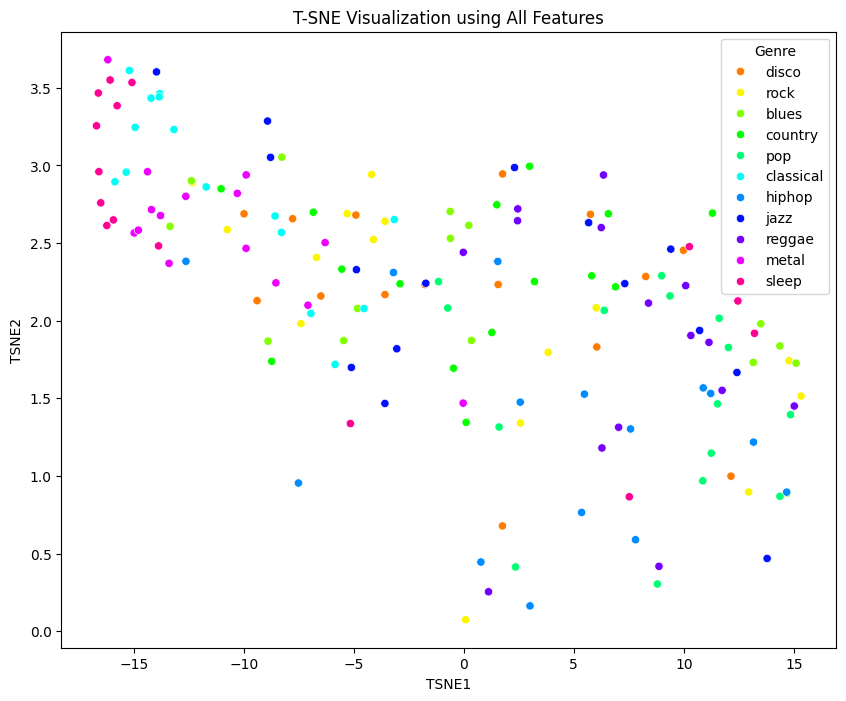

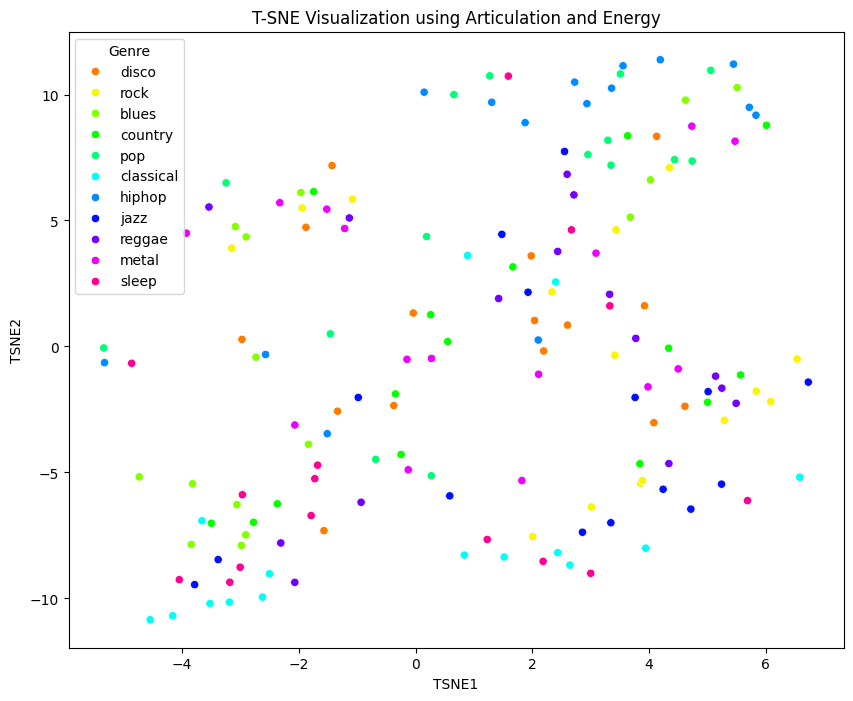

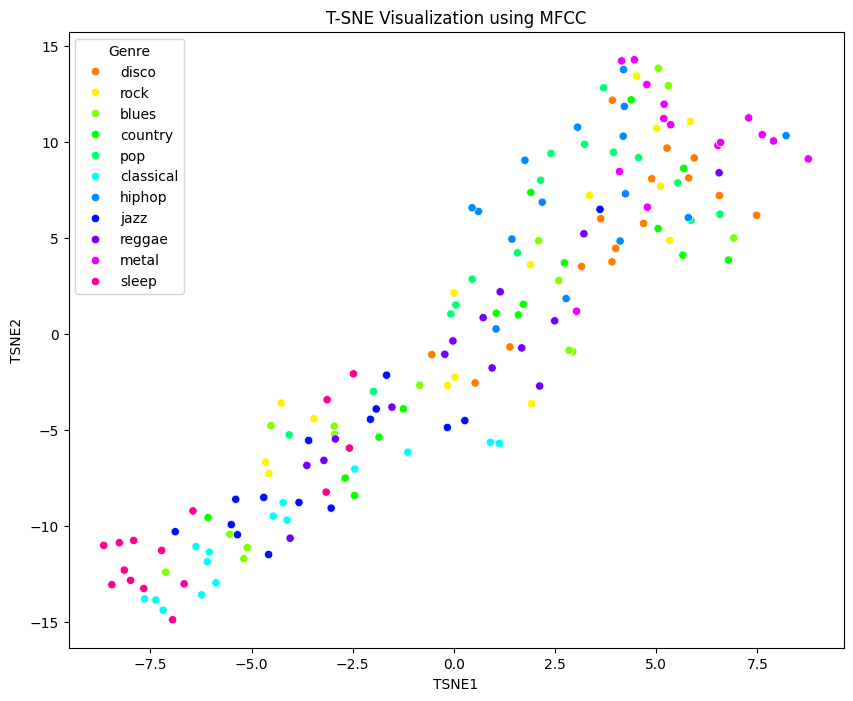

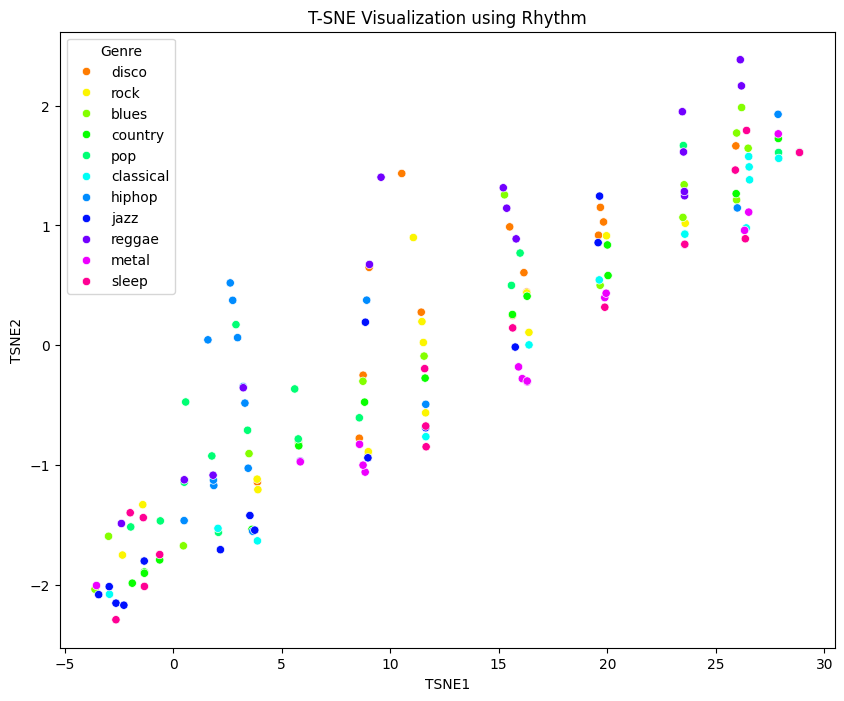

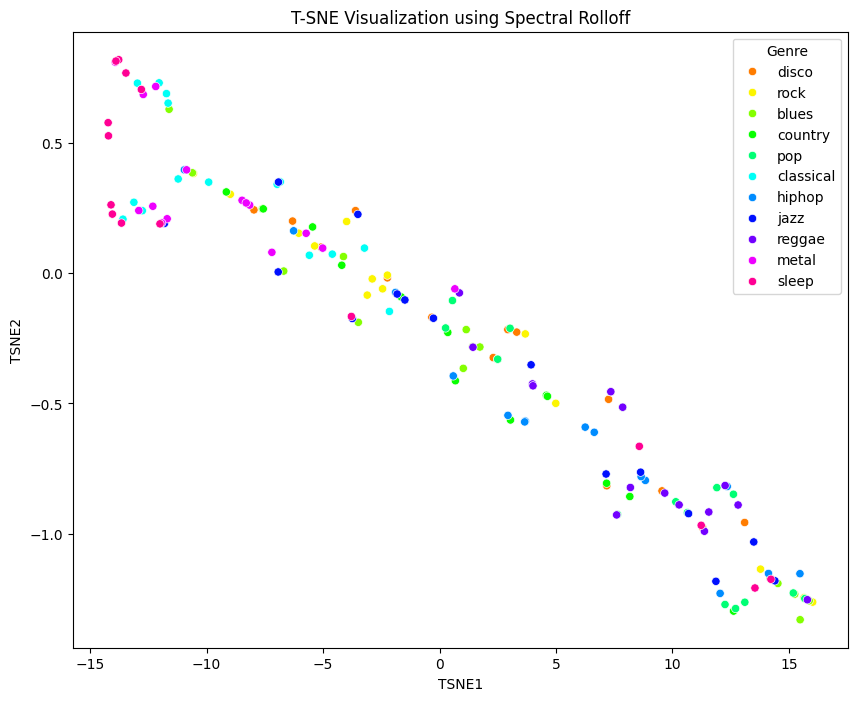

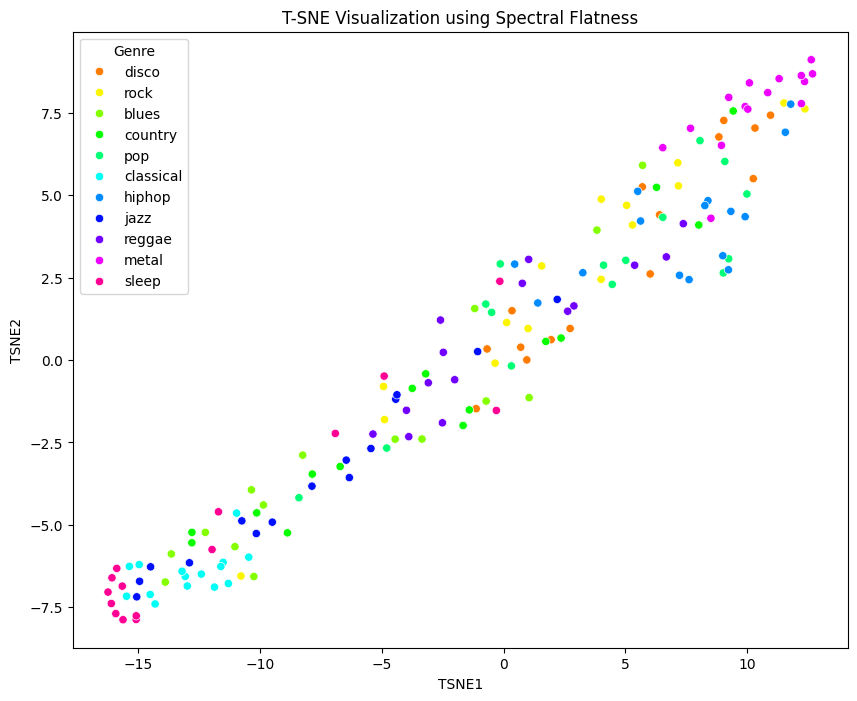

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Define feature groups according to the paper
articulation_energy_features = ['asr', 'rms_mean', 'rms_var', 'rms_std']
mfcc_features = [f'mfcc{i}_mean' for i in range(1, 21)]
rhythm_features = ['oenv_mean', 'oenv_var', 'oenv_std', 'tempo']
spectral_rolloff_features = ['rolloff_mean', 'rolloff_var', 'rolloff_std']
spectral_flatness_features = ['flatness_mean', 'flatness_var', 'flatness_std']

# Grouping for visualization
feature_groups = {
    'All Features': features_df.columns[1:-1].tolist(),
    'Articulation and Energy': articulation_energy_features,
    'MFCC': mfcc_features,
    'Rhythm': rhythm_features,
    'Spectral Rolloff': spectral_rolloff_features,
    'Spectral Flatness': spectral_flatness_features
}

# Manually specify a color palette with enough unique colors
unique_labels = features_df['label'].unique()
palette = sns.color_palette("hsv", len(unique_labels))

# Function to plot t-SNE
def plot_tsne(features, title):
    X = features_df[features].values
    y = features_df['label'].values
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    
    tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    tsne_df['label'] = y
    
    plt.figure(figsize=(5,4))
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='label', data=tsne_df, palette=palette)
    plt.title(title)
    plt.legend(loc='best', title='Genre')
    plt.show()

# Generate t-SNE plots for each feature group
for name, features in feature_groups.items():
    plot_tsne(features, f'T-SNE Visualization using {name}')


# Load Audio Datasets

In [26]:
import librosa
import os
import numpy as np
from tqdm import tqdm

def load_and_preprocess_audio(file_path, duration=30, sr=16000):
    # Load the audio file
    audio, _ = librosa.load(file_path, sr=sr, duration=duration, mono=True)
    return audio

# Example: Load and preprocess all files in a directory
sleep_music_dir = '../cache/spotify_sleep_dataset/waveform'

sleep_music_files = [os.path.join(sleep_music_dir, f) for f in os.listdir(sleep_music_dir) if (f.endswith('.wav') or f.endswith('.mp3'))]

# Using tqdm for progress tracking
sleep_music = {_file:load_and_preprocess_audio(_file) for _file in tqdm(sleep_music_files, desc="Processing sleep music files")}


### Extract Musical Features

In [28]:
def calculate_asr(audio):
    rms = librosa.feature.rms(y=audio)
    mean_rms = np.mean(rms)
    silence_ratio = np.mean(rms < mean_rms)
    return silence_ratio

def calculate_energy_features(audio):
    rms = librosa.feature.rms(y=audio)
    return np.mean(rms), np.var(rms), np.std(rms)

def calculate_mfcc_features(audio, sr=16000):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    return np.mean(mfccs, axis=1)

def calculate_rhythm_features(audio, sr=16000):
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    return tempo, np.mean(onset_env), np.var(onset_env), np.std(onset_env)

def calculate_spectral_rolloff(audio, sr=16000):
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85)
    return np.mean(rolloff), np.var(rolloff), np.std(rolloff)

def calculate_spectral_flatness(audio):
    flatness = librosa.feature.spectral_flatness(y=audio)
    return np.mean(flatness), np.var(flatness), np.std(flatness)

def normalize_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)



# Calculate ASR for all music pieces
# sleep_asr = [calculate_asr(audio) for audio in sleep_music]
# other_asr = [calculate_asr(audio) for audio in other_music]


In [27]:
len(sleep_music)

11482

In [31]:
from tqdm import tqdm

sleep_asr = {audio_file: calculate_asr(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating ASR")}
sleep_energy = {audio_file: calculate_energy_features(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating Energy Features")}
sleep_mfcc_features = {audio_file: calculate_mfcc_features(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating MFCC Features")}
sleep_rhythm_features = {audio_file: calculate_rhythm_features(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating Rhythm Features")}
sleep_spectral_rolloff = {audio_file: calculate_spectral_rolloff(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating Spectral Rolloff")}
sleep_spectral_flatness = {audio_file: calculate_spectral_flatness(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating Spectral Flatness")}

Calculating Spectral Flatness: 100%|██████████| 11482/11482 [04:57<00:00, 38.58it/s]


In [33]:
import pandas as pd

all_features = {}
for audio_file in sleep_music.keys():
    all_features[audio_file] = {
        "ASR": sleep_asr[audio_file],
        "Energy": sleep_energy[audio_file],
        "MFCC": sleep_mfcc_features[audio_file],
        "Rhythm": sleep_rhythm_features[audio_file],
        "Spectral Rolloff": sleep_spectral_rolloff[audio_file],
        "Spectral Flatness": sleep_spectral_flatness[audio_file],
    }

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(all_features, orient='index')

# Save the DataFrame to a CSV file
df.to_csv("sleep_music_features.csv", index_label="Audio File")

print("CSV file 'sleep_music_features.csv' has been created.")

Calculating ASR:   2%|▏         | 277/11482 [1:46:27<71:46:33, 23.06s/it]


CSV file 'sleep_music_features.csv' has been created.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Concatenate features for clustering
sleep_features = np.hstack([normalized_sleep_asr, normalized_sleep_energy, sleep_mfcc_features, 
                            sleep_rhythm_features, sleep_spectral_rolloff, sleep_spectral_flatness])

other_features = np.hstack([normalized_other_asr, normalized_other_energy, other_mfcc_features, 
                            other_rhythm_features, other_spectral_rolloff, other_spectral_flatness])

all_features = np.vstack([sleep_features, other_features])
labels = np.array([0] * len(sleep_features) + [1] * len(other_features))

# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(all_features)
predicted_labels = kmeans.labels_

# Calculate ARS and Silhouette Coefficient
ars = adjusted_rand_score(labels, predicted_labels)
sc = silhouette_score(all_features, predicted_labels)

print(f'Adjusted Rand Score (ARS): {ars}')
print(f'Silhouette Coefficient (SC): {sc}')

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=0)
tsne_results = tsne.fit_transform(all_features)

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='coolwarm')
plt.title('t-SNE Visualization of Music Features')
plt.show()


# Test Mel Spectrogram Generation variables

In [5]:
import subprocess

for hop_length in [64, 128, 256, 512, 1024]:
    for n_fft in [256, 512, 1024, 2048, 4096]:
        print(f'Running hop_length {hop_length} and n_fft {n_fft}')
        result = subprocess.run([
            "python", "/home/th716/audio-diffusion/scripts/audio_to_images.py",
            "--resolution", "512,128",
            "--hop_length", str(hop_length),
            "--n_fft", str(n_fft),
            "--input_dir", "/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024",
            "--output_dir", f"/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/mel_spec_512_128_hl_{hop_length}_nfft_{n_fft}"
        ])
        
        # Check for errors in the subprocess call
        if result.returncode != 0:
            print(f"Error with hop_length={hop_length} and n_fft={n_fft}")
            print(result.stderr)

Running hop_length 64 and n_fft 256
['/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/35986.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/35253.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/46220.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/42510.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/42897.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/50145.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/34620.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/38647.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/47544.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/35377.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/47595.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_d

  0%|          | 0/978 [00:00<?, ?it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Saving the dataset (2/2 shards): 100%|██████████| 19564/19564 [00:01<00:00, 13097.51 examples/s]


Running hop_length 64 and n_fft 512
['/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/35986.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/35253.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/46220.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/42510.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/42897.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/50145.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/34620.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/38647.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/47544.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/35377.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/47595.wav', '/home/th716/audio-diffusion/cache/spotify_sleep_d

 61%|██████    | 594/978 [02:07<01:23,  4.62it/s]

KeyboardInterrupt: 

In [ ]:
accelerate launch --config_file /home/th716/rds/hpc-work/audio-diffusion/config/accelerate_local.yaml \
/home/th716/rds/hpc-work/audio-diffusion/scripts/evaluation.py \
--reference_paths /home/th716/rds/hpc-work/audio-diffusion/cache/spotify_sleep_dataset/waveform \
/home/th716/rds/hpc-work/audio-diffusion/cache/fma_pop/waveform \
/home/th716/rds/hpc-work/audio-diffusion/cache/musiccaps/waveform \
--generated_path /home/th716/rds/hpc-work/audio-diffusion/models/ra_ssd_512_128/model_step_50000/samples/audio/sch_ddpm_nisteps_1000 \
--log_dir /home/th716/rds/hpc-work/audio-diffusion/models/ra_ssd_512_128/model_step_50000/samples/sch_ddpm_nisteps_1000 \
--metric frechet_audio_distance \
--model_names clap-laion-audio clap-laion-music vggish


In [28]:
from diffusers import (AutoencoderKL, DDIMScheduler, DDPMScheduler,
                       UNet2DConditionModel, UNet2DModel, Mel)
from datasets import load_dataset, load_from_disk

mel = Mel(
    x_res=512,
    y_res=128,
    hop_length=64,
    sample_rate=44100,
    n_fft=1024,
    n_iter=32
)

dataset_name = "../cache/spotify_sleep_dataset/waveform_1024/mel_spec_512_128_hl_64_nfft_1024/train"
# dataset_name = "../cache/spotify_sleep_dataset/mel_spec_512_128/train"
dataset = load_from_disk(dataset_name)

for i, d in enumerate(dataset):
    if i>50 and i<55:
        print(d)
        img = d['image']
        audio = mel.image_to_audio(img)
        print(audio.shape)
        display(Audio(audio, rate=44100))
    if i>55:
        break

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x128 at 0x7CC9EB9DAF10>, 'audio_file': '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/46220.wav', 'slice': 11}
(32704,)


{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x128 at 0x7CCA402B4AD0>, 'audio_file': '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/46220.wav', 'slice': 12}
(32704,)


{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x128 at 0x7CCA402E7210>, 'audio_file': '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/46220.wav', 'slice': 13}
(32704,)


{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x128 at 0x7CCA402E5610>, 'audio_file': '/home/th716/audio-diffusion/cache/spotify_sleep_dataset/waveform_1024/46220.wav', 'slice': 14}
(32704,)


In [10]:
import numpy as np
from IPython.display import Audio

# Example: Generating a sine wave as an audio signal
duration = 2.0  # seconds
sample_rate = 44100  # Hz
frequency = 440.0  # Hz (A4 tone)

t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
audio = 0.5 * np.sin(2 * np.pi * frequency * t)

# Play the audio in Jupyter Notebook
Audio(audio, rate=sample_rate)
